In [ ]:
from pathlib import Path
import torch
from transformers import AutoTokenizer, AutoModel, AutoConfig
from Bio import SeqIO    
from collections import Counter
import numpy as np                           
from tqdm import tqdm  
import pandas as pd
import math
from sklearn.cluster import KMeans
import umap
import matplotlib.pyplot as plt

from scipy.stats import pearsonr

from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [ ]:
windows_fasta_path = Path("../outputs/windows.fasta")  
windows_tsv_path = Path("../outputs/windows.tsv")      

model_name = "InstaDeepAI/agro-nucleotide-transformer-1b"
device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained(model_name, )
model = AutoModel.from_pretrained(model_name, dtype=torch.float32)
model.to(device)
model.eval()

# Transformer inference utils

In [ ]:
def iter_windows(path):
    """Stream (id, seq) pairs from a FASTA file."""
    with open(path) as handle:
        for record in SeqIO.parse(handle, "fasta"):
            yield record.id, str(record.seq)


def batch_iter(iterator, size):
    """Group items from an iterator into batches of length `size`."""
    batch = []
    for item in iterator:
        batch.append(item)
        if len(batch) == size:
            yield batch
            batch = []
    if batch:
        yield batch


def mean_pool(last_hidden_state, attention_mask):
    # last_hidden_state: (B, L, H)
    # attention_mask:    (B, L)

    # Drop CLS (position 0)
    last_hidden_state = last_hidden_state[:, 1:, :]   # (B, L-1, H)
    attention_mask    = attention_mask[:, 1:]         # (B, L-1)

    mask = attention_mask.unsqueeze(-1).to(last_hidden_state.dtype)  # (B, L-1, 1)
    masked_embeddings = last_hidden_state * mask                     # (B, L-1, H)
    summed  = masked_embeddings.sum(dim=1)                           # (B, H)
    counts  = mask.sum(dim=1).clamp(min=1.0)                         # (B, 1)
    pooled  = summed / counts                                        # (B, H)
    return pooled

In [ ]:
cfg = AutoConfig.from_pretrained("InstaDeepAI/agro-nucleotide-transformer-1b")

def format_fields(cfg, fields):
    lines = []
    for label, attr in fields:
        value = getattr(cfg, attr, None)
        lines.append(f"{label}: {value}")
    return "\n".join(lines)

fields = [
    ("Model type", "model_type"),
    ("Architectures", "architectures"),
    ("Layers", "num_hidden_layers"),
    ("Hidden size", "hidden_size"),
    ("Attention heads", "num_attention_heads"),
    ("FFN inner dim", "intermediate_size"),
    ("Max position embeddings", "max_position_embeddings"),
    ("Pad token id", "pad_token_id"),
    ("Mask token id", "mask_token_id"),
]
print(format_fields(cfg, fields))

Model type: esm
Architectures: ['EsmForMaskedLM']
Layers: 40
Hidden size: 1500
Attention heads: 20
FFN inner dim: 5120
Max position embeddings: 1026
Pad token id: 1
Mask token id: 2


# Inference

This block processes nucleotide windows in batches, runs them through the model, and collects their embeddings.  
A streaming iterator reads windows from the FASTA file, and `batch_iter` groups them into batches of size `batch_size`.  
Each batch is tokenized with padding and optional truncation at `max_length`. Sequences that reach the token budget are counted as potentially truncated.

The model runs in inference mode without gradients. After the forward pass, mean pooling over non-padding tokens (excluding CLS) produces one embedding per sequence. These embeddings are moved to CPU and stored.

All batch embeddings are concatenated into a single tensor of shape `(N, H)`, converted to a NumPy array, and saved for downstream analysis.  
The script prints the final embedding matrix shape and warns if any sequences reached the token limit.


In [ ]:
batch_size = 8
max_length = 1024

all_ids = []
all_embeddings = []

iterator = iter_windows(windows_fasta_path)

for batch in tqdm(batch_iter(iterator, batch_size)):
    batch_ids, seqs = zip(*batch)

    enc = tokenizer(
        list(seqs),
        return_tensors="pt",
        padding="longest",
        truncation=True,
        max_length=max_length,
    )

    enc = {k: v.to(device) for k, v in enc.items()}

    with torch.no_grad():
        outputs = model(**enc)
        pooled = mean_pool(outputs.last_hidden_state, enc["attention_mask"])

    all_ids.extend(batch_ids)
    all_embeddings.append(pooled.cpu())

if not all_embeddings:
    raise RuntimeError("No embeddings computed.")

embeddings_tensor = torch.cat(all_embeddings, dim=0)
embeddings = embeddings_tensor.numpy().astype("float32")

print(f"Embeddings shape: {embeddings.shape}")


1250it [16:42,  1.25it/s]

Embeddings shape: (10000, 1500)


In [ ]:
output_dir = Path("../outputs")
output_dir.mkdir(exist_ok=True)

In [ ]:
npz_path = output_dir / "window_embeddings_agro_transformer.npz"
np.savez(npz_path, ids=np.array(all_ids), embeddings=embeddings)        


We also extract the CLS embeddings simply to explore whether they provide different or complementary information compared to the mean-pooled representations. At this stage we are comparing both to see which one is more useful for downstream analyses.


In [ ]:
all_cls_embeddings = []
iterator = iter_windows(windows_fasta_path)

for batch in tqdm(batch_iter(iterator, batch_size)):
    batch_ids, seqs = zip(*batch)

    enc = tokenizer(
        list(seqs),
        return_tensors="pt",
        padding="longest",
        truncation=True,
        max_length=max_length,
    )

    enc = {k: v.to(device) for k, v in enc.items()}

    with torch.no_grad():
        outputs = model(**enc)
        cls_embeddings = outputs.last_hidden_state[:, 0, :]

    all_cls_embeddings.append(cls_embeddings.cpu())

embeddings_tensor = torch.cat(all_cls_embeddings, dim=0)
embeddings = embeddings_tensor.numpy().astype("float32")


1250it [16:40,  1.25it/s]

Embeddings shape: (10000, 1500)


In [ ]:
npz_path = output_dir / "window_embeddings_agro_transformer_cls.npz"
np.savez(npz_path, ids=np.array(all_ids), embeddings=embeddings)        

In [38]:
cls_embeddings = np.load(output_dir / "window_embeddings_agro_transformer_cls.npz")['embeddings']
nt_embeddings = np.load(output_dir / "window_embeddings_agro_transformer.npz")['embeddings']

In [ ]:
df = pd.read_csv(windows_tsv_path, sep="\t")  
# Align the TSV to the embedding order
df = df.set_index("id").loc[all_ids]
gc = df["gc_pct"].values  # shape: (N,)


# Evaluation

To get a first sense of whether any embedding dimensions relate to GC content, we compute the Pearson correlation between each dimension of the embeddings and the GC values.  
This is not a full model or a causal analysis; it is a quick diagnostic to see whether certain coordinates carry signal relevant to sequence composition.

We compute these correlations separately for the mean-pooled embeddings and the CLS embeddings, then report the largest absolute correlation (and its R²) in each case.  

Taking the maximum absolute value highlights the single strongest association in the embedding space, regardless of direction.  

This should be interpreted cautiously: a high value does not imply that most dimensions are informative, only that at least one coordinate shows a measurable relationship with GC content.

This step helps us compare both embedding types and understand whether either representation captures simple compositional features before moving on to more complex analyses.


In [ ]:
def dim_correlations(X, y):
    corrs = []
    for j in range(X.shape[1]):
        r, _ = pearsonr(X[:, j], y)
        corrs.append(r)
    return np.array(corrs)

corrs_mean = dim_correlations(nt_embeddings, gc)
corrs_cls  = dim_correlations(cls_embeddings, gc)
# might be explaning AT content if negativ (still informative)
print("Max |r| (mean-pooled):", np.max(np.abs(corrs_mean))) 
print("Max |r| (CLS):", np.max(np.abs(corrs_cls))) 
print("Max R^2 (mean-pooled):", np.max(corrs_mean**2))
print("Max R^2 (CLS):", np.max(corrs_cls**2))


Max |r| (mean-pooled): 0.829570438931206
Max |r| (CLS): 0.7316514251619732
Max R^2 (mean-pooled): 0.6881871131485138
Max R^2 (CLS): 0.5353138079415465


The strongest GC–embedding association is higher for the mean-pooled embeddings than for the CLS vectors.  
 
This suggests that mean pooling captures GC-related variation more directly or more sharply than the CLS token.  

It does not mean that every dimension is GC-informative, only that the most GC-aligned axis is stronger in the pooled representation. 
 
Overall, mean pooling appears to provide a somewhat clearer signal for this simple compositional feature.


After inspecting individual embedding dimensions, the next step is to assess how well the full embedding spaces predict GC content when used together. 

A ridge regression with cross-validation provides a simple way to test whether the information relevant to GC content is spread across many coordinates rather than concentrated in a single axis. 

By comparing performance between mean-pooled and CLS embeddings, we can see which representation offers a more coherent or distributed encoding of this compositional feature.  

This evaluation helps determine whether GC-related signal is genuinely captured by the embedding space as a whole, rather than being an artifact of a single highly correlated dimension.


In [58]:
def evaluate_gc_regression(X, y, alpha=1.0):
    model = make_pipeline(
        StandardScaler(),     # important to scale features for ridge regression
        Ridge(alpha=alpha)
    )
    scores = cross_val_score(model, X, y, cv=20, scoring="r2")
    return scores

scores_mean = evaluate_gc_regression(nt_embeddings, gc)
scores_cls  = evaluate_gc_regression(cls_embeddings, gc)

print("Mean R^2 (mean-pooled):", scores_mean.mean(), "+/-", scores_mean.std())
print("Mean R^2 (CLS):", scores_cls.mean(), "+/-", scores_cls.std())


Mean R^2 (mean-pooled): 0.991190479057531 +/- 0.0013259182667690965
Mean R^2 (CLS): 0.9832785657576203 +/- 0.002336097795210492


Both embedding types allow GC content to be predicted extremely well, with cross-validated R² values above 0.98.  

Mean-pooled embeddings perform slightly better, reaching an average R² of about 0.99 compared to about 0.98 for the CLS vectors.  

This suggests that GC information is not only present in individual dimensions but is also distributed across the embedding space in a way that linear models can recover with high accuracy. 
 
The difference between the two representations is modest, but the pooled embeddings provide a marginally clearer and more consistent signal.


Because we evaluate performance using 20-fold cross-validation, the high R² values are unlikely to be caused by overfitting.  

The model is repeatedly trained on one subset of windows and tested on held-out windows it has never seen, so the reported scores reflect out-of-sample performance rather than training fit.  

Given that GC content is a simple, smoothly varying property of the sequences, and that the embeddings encode it in a mostly linear way, achieving very high R² without overfitting is expected.  

The narrow standard deviations across folds further suggest that the relationship is stable rather than the result of memorization or variance in the folds.


After checking how well embeddings capture GC content, we next look at a more nuanced sequence property: local sequence complexity.  

To do this, we compute a 4-mer entropy per window, which summarizes how diverse the 4-mers are within each sequence (high entropy = many different k-mers with similar frequencies; low entropy = repetitive or low-complexity sequence).

By mapping each window ID back to its raw sequence and computing k-mer entropy, we obtain another scalar label per window that is not trivially identical to GC content but still reflects basic sequence structure.  

This allows us to test whether the embeddings encode broader aspects of sequence organization (e.g. repetitiveness vs. complexity), rather than just simple compositional features like GC.


In [134]:
def kmer_entropy(seq, k=4):
    kmers = [seq[i:i+k] for i in range(len(seq)-k+1) if "N" not in seq[i:i+k]]
    freqs = Counter(kmers)
    total = sum(freqs.values())
    if total == 0:
        return 0
    return -sum((c/total) * math.log2(c/total) for c in freqs.values())
id_to_seq = {}

with open(windows_fasta_path) as handle:
    for record in SeqIO.parse(handle, "fasta"):
        id_to_seq[record.id] = str(record.seq).upper()
entropy = np.array([kmer_entropy(id_to_seq[i]) for i in all_ids])

At this stage we have shown that individual embedding dimensions and linear models can recover GC content and sequence entropy.  

To understand how these properties are organized in the full embedding space, we project the high-dimensional embeddings into two dimensions using UMAP.

This gives a qualitative view of the geometry of the representation: whether sequences with similar GC or similar entropy cluster together, whether these properties form smooth gradients, and whether the embeddings capture structure beyond simple scalar correlations.

Coloring the UMAP projection by GC content and by k-mer entropy allows us to see how these sequence-level attributes align with the global layout of the embedding space.  

This helps assess whether the model organizes sequences meaningfully at a broader scale, rather than only encoding isolated numerical correlations.


/opt/homebrew/Caskroom/miniforge/base/envs/plantomics/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


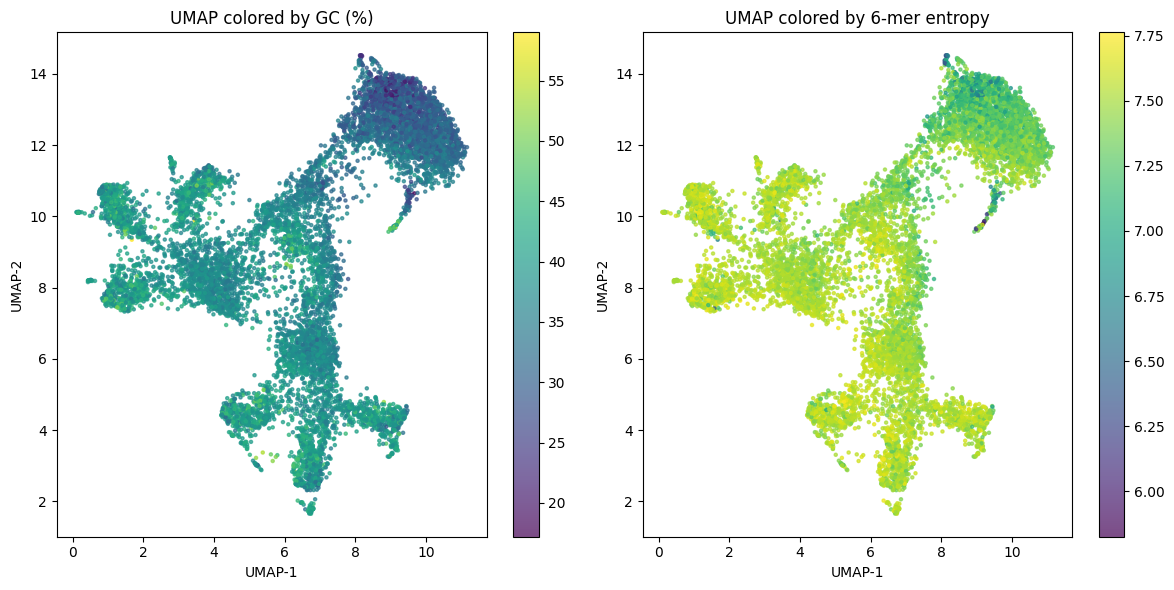

In [ ]:
X = nt_embeddings   
gc_subset = gc

X_scaled = StandardScaler().fit_transform(X)

reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric="cosine",
    random_state=42,
)
X_2d = reducer.fit_transform(X_scaled)  # shape: (N, 2)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sc1 = axes[0].scatter(
    X_2d[:, 0], X_2d[:, 1],
    c=gc_subset,
    s=5,
    cmap="viridis",
    alpha=0.7
)
axes[0].set_title("UMAP colored by GC (%)")
axes[0].set_xlabel("UMAP-1")
axes[0].set_ylabel("UMAP-2")
plt.colorbar(sc1, ax=axes[0])

sc2 = axes[1].scatter(
    X_2d[:, 0], X_2d[:, 1],
    c=entropy,
    s=5,
    cmap="viridis",
    alpha=0.7
)
axes[1].set_title("UMAP colored by 4-mer entropy")
axes[1].set_xlabel("UMAP-1")
axes[1].set_ylabel("UMAP-2")
plt.colorbar(sc2, ax=axes[1])

plt.tight_layout()
plt.show()


We compute the correlation between GC content and k-mer entropy to understand how dependent these two sequence properties are.  

If they are strongly correlated, then any structure we see in the embeddings with respect to entropy might simply reflect GC content rather than an independent signal.  

If the correlation is weak or moderate, then entropy captures a different aspect of the sequences, and examining how the embeddings reflect it can tell us whether the model encodes information beyond basic composition.


In [136]:
from scipy.stats import pearsonr
r, pval = pearsonr(gc, entropy)
print("GC–entropy correlation:", r)


GC–entropy correlation: 0.7988968005721715


GC content and 4-mer entropy are strongly correlated (r ≈ 0.80).  

This means a substantial portion of the variation in entropy can be explained by GC alone.  

As a result, any structure in the embeddings that aligns with entropy may partly reflect the model’s sensitivity to GC rather than an independent notion of sequence complexity.  

Entropy still provides additional information, but it is not fully orthogonal to GC in this dataset.


After examining how GC content and entropy align with the embedding space, we cluster the embeddings directly using K-means.  

This allows us to see whether the model’s representation naturally separates windows into distinct groups without using any sequence-derived labels.  

Projecting these cluster assignments onto the UMAP visualization shows how well the unsupervised clusters correspond to the geometric structure seen earlier.

If the clusters form coherent regions in UMAP, it suggests that the embedding space contains meaningful discrete structure.  

We can then compare these clusters to GC, entropy, or other biological variables to understand what properties the model is grouping together.  

This step helps evaluate whether the embeddings capture higher-level patterns beyond simple continuous gradients.


Cluster counts: [1500  315 1135 1105  337  313 1465 1362  304  243 1632  289]


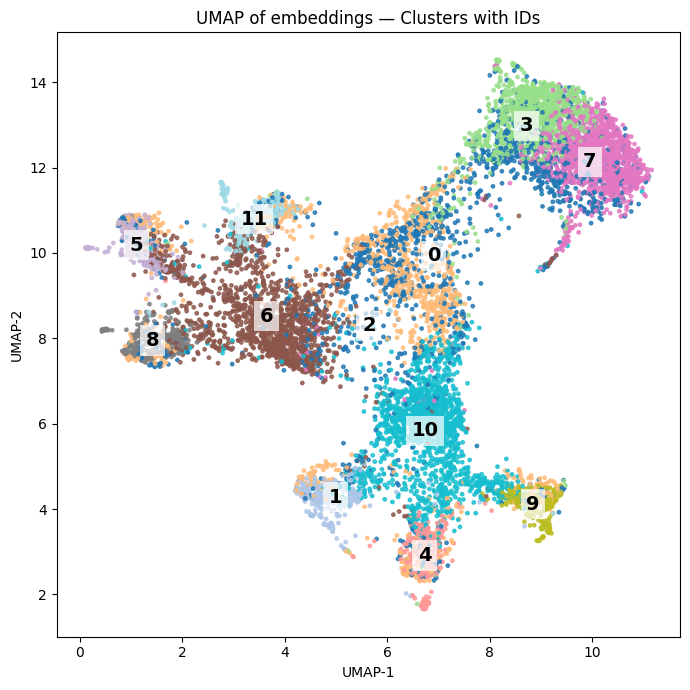

In [ ]:
K = 12  
kmeans = KMeans(n_clusters=K,  n_init="auto")
labels = kmeans.fit_predict(X_scaled)   

plt.figure(figsize=(7, 7))

sc = plt.scatter(
    X_2d[:, 0], X_2d[:, 1],
    c=labels,
    cmap="tab20",
    s=6,
    alpha=0.8
)

unique_clusters = [c for c in np.unique(labels) if c != -1]  # skip noise

for c in unique_clusters:
    mask = labels == c
    x_center = X_2d[mask, 0].mean()
    y_center = X_2d[mask, 1].mean()
    
    plt.text(
        x_center,
        y_center,
        str(c),
        fontsize=14,
        fontweight='bold',
        color='black',
        ha='center',
        va='center',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
    )
plt.title(f"UMAP of embeddings — Clusters with IDs")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()


After defining clusters in embedding space, we now ask what makes these clusters different at the sequence level.  
To do this, we characterize each cluster using classical sequence features:

- k-mer enrichment: for each cluster and k (3–6), we compute log₂ enrichment of k-mers relative to the global background. This shows which short sequence patterns are over- or underrepresented in each embedding cluster.
- repeat structure: we quantify homopolymer length (longest run of the same base) and the density of simple repeat motifs (e.g. ATAT, AAAAA) per sequence, and then summarize these features per cluster.

By aligning embedding-derived clusters with k-mer enrichment profiles and repeat statistics, we can interpret what the model is grouping together. 
 
If certain clusters are enriched for specific motifs, homopolymers, or simple repeats, this links the abstract embedding structure back to concrete sequence patterns and helps explain what the model has learned.


In [ ]:
df_seq = pd.DataFrame({
    "id": all_ids,
    "cluster": labels,
    "seq": [id_to_seq[i] for i in all_ids],
})

df_clusters = df_seq[df_seq["cluster"] != -1].copy()



k = 3
[k=3] 64 distinct k-mers
[k=3] enrichment matrix: (12, 64)


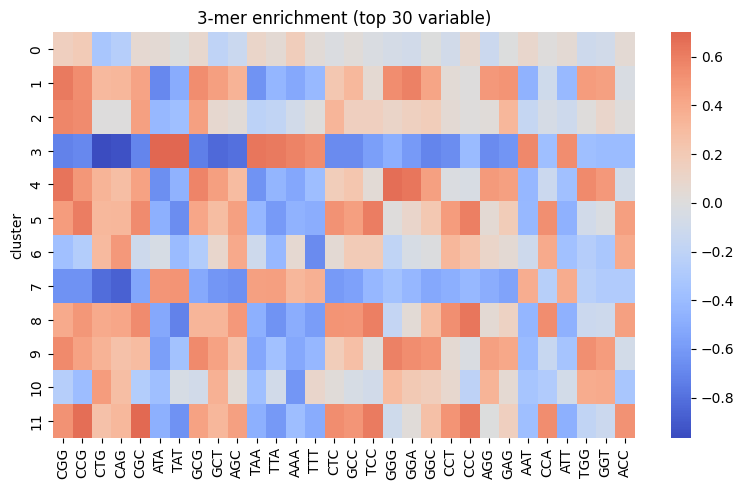


k = 4
[k=4] 256 distinct k-mers
[k=4] enrichment matrix: (12, 256)


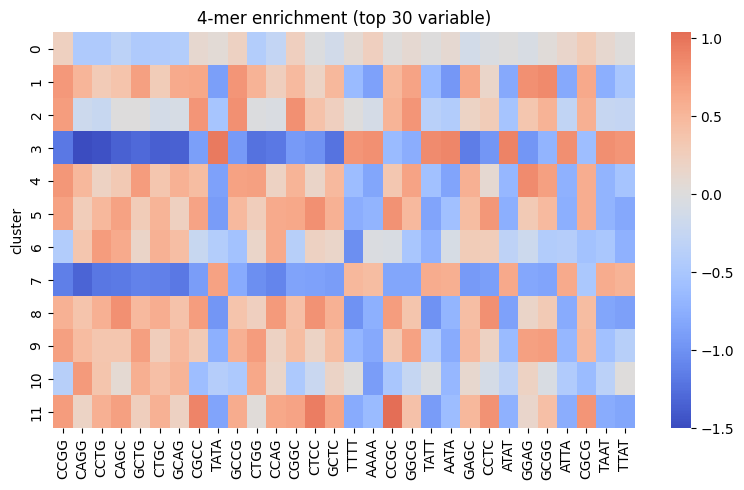


k = 5
[k=5] 1024 distinct k-mers
[k=5] enrichment matrix: (12, 1024)


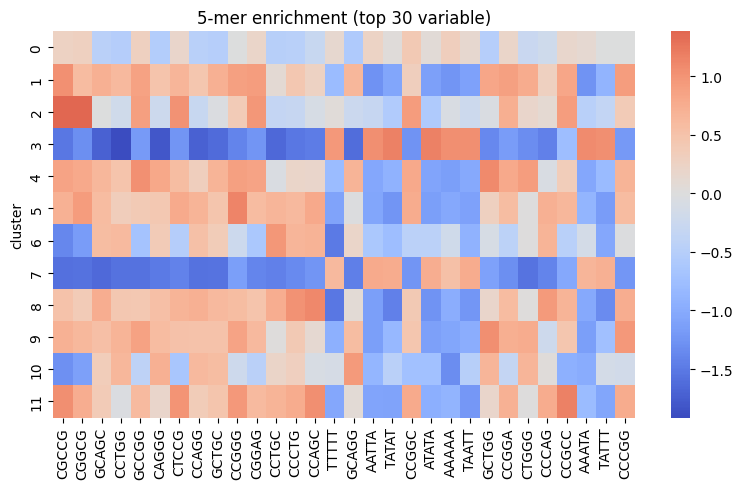


k = 6
[k=6] 4096 distinct k-mers
[k=6] enrichment matrix: (12, 4096)


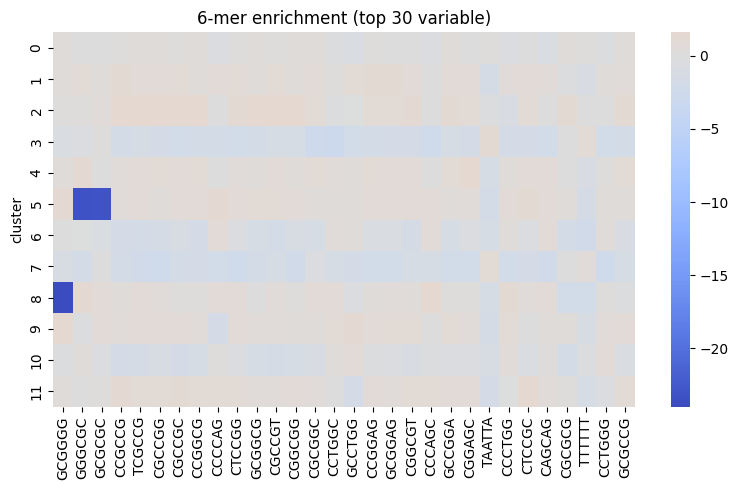

In [ ]:
def kmer_counts(seq, k, ignore_n=True):
    """Count k-mers in a sequence."""
    seq = seq.upper()
    out = Counter()
    L = len(seq)

    for i in range(L - k + 1):
        kmer = seq[i:i+k]
        if ignore_n and "N" in kmer:
            continue
        out[kmer] += 1

    return out


def compute_kmer_enrichment(df, k, ignore_n=True):
    """Compute log2 enrichment of k-mers per cluster."""
    # k-mer counts per sequence
    per_seq_counts = [kmer_counts(s, k, ignore_n) for s in df["seq"]]

    # global background
    global_ct = Counter()
    for c in per_seq_counts:
        global_ct.update(c)

    total_global = sum(global_ct.values())
    global_freq = {km: cnt / total_global for km, cnt in global_ct.items()}

    print(f"[k={k}] {len(global_freq)} distinct k-mers")

    # per-cluster frequencies
    cluster_freq = {}
    for cl, df_cl in df.groupby("cluster"):
        ct = Counter()
        for s in df_cl["seq"]:
            ct.update(kmer_counts(s, k, ignore_n))

        total = sum(ct.values())
        if total == 0:
            f = {km: 0.0 for km in global_freq}
        else:
            f = {km: ct.get(km, 0) / total for km in global_freq}

        cluster_freq[cl] = f

    # log2 enrichment matrix
    clusters = sorted(cluster_freq)
    kmers = sorted(global_freq)

    rows = []
    for cl in clusters:
        freq_cl = cluster_freq[cl]
        row = {"cluster": cl}
        for km in kmers:
            bg = global_freq.get(km, 1e-12)
            fc = freq_cl.get(km, 0.0)
            row[km] = math.log2((fc + 1e-12) / (bg + 1e-12))
        rows.append(row)

    df_enrich = pd.DataFrame(rows).set_index("cluster")
    print(f"[k={k}] enrichment matrix: {df_enrich.shape}")

    return df_enrich


# run for multiple k
ks = [3, 4, 5, 6]

for k in ks:
    print("\n" + "="*60)
    print(f"k = {k}")
    df_enrich = compute_kmer_enrichment(df_clusters, k, ignore_n=True)

    # pick top 30 most variable kmers
    var = df_enrich.var(axis=0)
    top = var.sort_values(ascending=False).head(30).index

    plt.figure(figsize=(8, 5))
    sns.heatmap(df_enrich[top], cmap="coolwarm", center=0)
    plt.title(f"{k}-mer enrichment (top 30 variable)")
    plt.tight_layout()
    plt.show()


/var/folders/kq/_ntfn5zx1b199xp4vyd82t840000gn/T/ipykernel_6401/4176193249.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(runs_per_cluster, labels=clusters, showfliers=False)


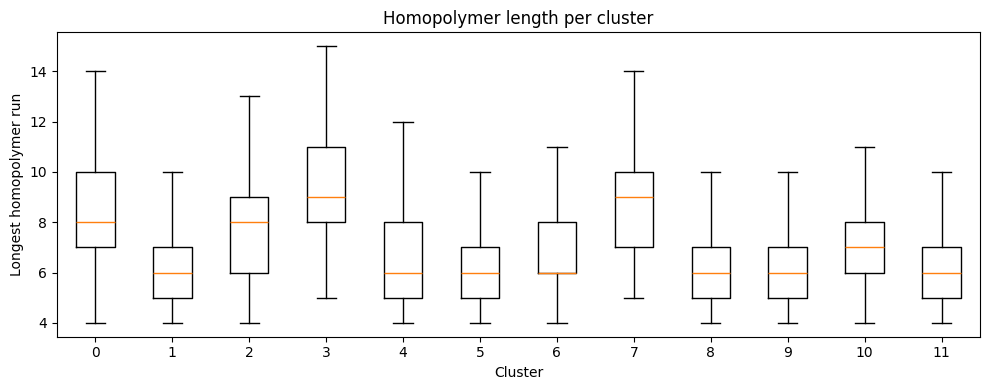

In [ ]:
def longest_run(seq):
    """Longest run of same base."""
    if not seq:
        return 0
    seq = seq.upper()
    max_run = 1
    cur = 1
    for i in range(1, len(seq)):
        if seq[i] == seq[i-1]:
            cur += 1
            max_run = max(max_run, cur)
        else:
            cur = 1
    return max_run

# compute homopolymer feature
df_clusters["longest_run"] = df_clusters["seq"].map(longest_run)

df_clusters[["id", "cluster", "longest_run"]].head()

# cluster-level summary
df_repeat_summary = (
    df_clusters
    .groupby("cluster")["longest_run"]
    .agg(["mean", "std", "max"])
)
df_repeat_summary

# boxplot of homopolymer lengths per cluster
plt.figure(figsize=(10, 4))
runs_per_cluster = [
    df_clusters[df_clusters["cluster"] == c]["longest_run"].values
    for c in clusters
]

plt.boxplot(runs_per_cluster, labels=clusters, showfliers=False)
plt.xlabel("Cluster")
plt.ylabel("Longest homopolymer run")
plt.title("Homopolymer length per cluster")
plt.tight_layout()
plt.show()


The combined k-mer enrichment patterns, homopolymer statistics, and UMAP layout reveal a clear, interpretable structure in the embedding space.

### 1. AT-rich, low-complexity clusters (3 and 7)
Clusters **3** and **7** are strongly enriched for simple AT-rich motifs such as:

- TATA  
- TTTT  
- AAAAA  
- TATT  
- AATA  

They also exhibit the **highest homopolymer lengths** (median ≈ 9), indicating extended AT tracts and low-complexity sequence structure.  
In the UMAP projection, these clusters form one of the three major lobes.

### 2. Clusters depleted for GC-rich 6-mers (5 and 8)
Clusters **5** and **8** show the opposite pattern: they are **depleted** for GC-rich motifs such as:

- GCGGGG  
- GGGCGC  
- other GC-heavy 6-mers

These clusters occupy a distinct lobe in UMAP, reflecting their different compositional profile.

### 3. Intermediate or mixed-composition clusters (10, 1, 4, 9)
A third set of clusters—**10**, **1**, **4**, **9**—forms another lobe.  
These appear to represent **intermediate** or more **heterogeneous** sequence composition, lacking the strong AT bias of clusters 3/7 and the GC-structured profiles of clusters 5/8.

---

### Overall interpretation
The embedding space naturally organizes sequences into **three broad compositional regimes**:

1. **AT-rich, low-complexity sequences** (clusters 3 & 7)  
2. **GC-structured or AT-depleted sequences** (clusters 5 & 8)  
3. **Moderate or mixed-composition sequences** (clusters 10, 1, 4, 9)

This shows that the model’s embeddings capture meaningful sequence-level structure, and that the unsupervised clusters correspond closely to concrete compositional and motif-based differences.


# Critical assessment

#### Is the zero-shot approach sufficient for capturing GC content?

For GC content specifically, the zero-shot approach is effectively sufficient on this dataset.

- Using a simple linear ridge regression on the frozen embeddings, we obtain:
  - Mean-pooled embeddings: cross-validated R² ≈ 0.99  
  - CLS embeddings: cross-validated R² ≈ 0.98  
- These scores are out-of-sample (20-fold cross-validation) and have very small standard deviations, so they reflect genuine generalization rather than overfitting.


---

#### Criteria for “sufficient”

In this context, I would call the zero-shot representation “sufficient” for GC content if:

1. **High predictive performance**  
   - Cross-validated R² is very high (R² ≈ 0.98–0.99), indicating that most of the variance in GC can be explained from the embeddings.


2. **Stability across folds**  
   - Performance is consistent across cross-validation splits (low standard deviation of R²).
   - This is also satisfied: the reported standard deviations are small.

3. **Simple decoder**  
   - A linear model (ridge regression) is enough; no deep or highly nonlinear decoder is needed.

4. **Qualitative consistency**  
   - UMAP projections show smooth gradients with respect to GC and related measures (e.g. k-mer entropy), and clusters align with compositional differences.

Given these criteria, the current zero-shot setup is more than sufficient for *capturing* GC on this dataset.

---

#### If it is “insufficient”, in what sense?

While the zero-shot embeddings capture GC content extremely well, this does not mean they represent GC as a clean or isolated factor.  

Pretrained models typically encode GC together with other correlated properties—entropy, repeat content, low-complexity regions—because they were never trained to separate these influences. 

The result is a representation where GC is highly decodable but still **entangled** with multiple aspects of sequence composition.

This is similar to what we see in single-cell generative models: unsupervised latent spaces often conflate biological and technical sources of variation, and only with appropriate supervision or architectural constraints do we obtain disentangled representations.  

In my own work on disentanglement in single-cell VAEs, we found that relying on a pretrained or purely unsupervised model rarely yields axes corresponding cleanly to individual biological factors.  
Instead, factors such as batch, cell type, and perturbation effects merge unless we explicitly guide the model.

The same principle applies here.  

If a downstream task requires separating GC effects from other sequence-level properties—or suppressing GC entirely—zero-shot embeddings may be insufficient. The model has no reason to isolate GC on its own; it simply embeds it within a broader manifold of compositional variation.  

Fine-tuning becomes useful when the goal is to reshape the embedding space so that GC occupies an identifiable, controllable axis or becomes invariant to other factors. This could involve:

- supervised fine-tuning on GC to make it an explicit, disentangled dimension,  
- adversarial or contrastive objectives to *remove* GC sensitivity,  
- or multi-task setups that force the model to distribute different sequence properties across different components of the representation.

Thus, although zero-shot embeddings are entirely adequate for predicting GC, they may not be optimal when the objective is to **disentangle** GC from other correlated signals or when GC should be treated as a nuisance rather than a target.


---

#### When and why would fine-tuning be necessary?

Fine-tuning is not needed to *predict* GC content—the zero-shot embeddings already do that extremely well.  
Where fine-tuning becomes relevant is when your downstream goal requires the model to treat GC in a more controlled or interpretable way.

In practice, the kind of fine-tuning depends on your goal:

- **If you want GC-invariant embeddings:**  
  Add an adversarial term or contrastive penalty that discourages the encoder from encoding GC.  
  This is analogous to debiasing or batch-effect removal in single-cell VAEs.

- **If you want to learn new labels that are only weakly encoded now:**  
  Fine-tune on those labels directly, possibly in a multi-task setup where GC is included as an auxiliary task to help disentangle it from the new features of interest.

You can start from the pretrained encoder and either:
- train only a small prediction head,
- train low-rank adapters (e.g. LoRA), or



